In [38]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import torch, torch.nn as nn, torch.nn.functional as F, math
from torch import tensor
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler
import fastcore.all as fc
from functools import partial
from torchsummary import summary

from miniai.data import *
from miniai.learner import Learner, TrainLearner, MomentumLearner
from miniai.hooks import *
from miniai.custom_modules import conv, GeneralReLU
from miniai.callbacks import *
from miniai.plotting import show_images, show_image
from torch.utils.data import default_collate

In [2]:
data = pd.read_csv('data/fashion_mnist/train.csv')
data_test = pd.read_csv('data/fashion_mnist/test.csv')

In [3]:
X_train = (tensor(data.iloc[:, 1:].values)/255.).view(-1, 1, 28, 28)
y_train = tensor(data.iloc[:, 0].values)
X_valid = (tensor(data_test.iloc[:, 1:].values)/255.).view(-1, 1, 28, 28)
y_valid = tensor(data_test.iloc[:, 0].values)

In [4]:
class FashionDataset(Dataset):
    def __init__(self, x, y, mean=None, std=None):
        self.mean = mean; self.std = std
        if self.mean is None: self.mean = x.mean()
        if self.std is None: self.std = x.std()
        self.x = (x - self.mean) / self.std
        self.y = y

In [5]:
dset_train = FashionDataset(X_train[:2000], y_train[:2000])
dset_valid = FashionDataset(X_valid[:2000], y_valid[:2000], dset_train.mean, dset_train.std)

In [6]:
def collate_augment(batch):
    """
    batch: list of tuples (X_i, y_i)
    returns: tuple of two lists: (X, y)
    """
    X_b, y_b = default_collate(batch)
    X_b_augment = torch.where(X_b > -0.7, X_b+torch.rand_like(X_b)*0.2, X_b)
    return X_b_augment, y_b

In [7]:
dl_train = DataLoader(dset_train, batch_size=128, shuffle=True, collate_fn=collate_augment, num_workers=4)
dl_valid = DataLoader(dset_valid, batch_size=len(dset_valid), shuffle=False, num_workers=4)

In [8]:
dls = DataLoaders(dl_train, dl_valid)

In [9]:
X_b, y_b = next(iter(dls.train))

<br>**Model**

In [10]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [11]:
class ResBlock(nn.Module):
    def __init__(self, in_f, out_f, ks=3, stride=2, act=None, norm=None):
        super(ResBlock, self).__init__()
        self.conv1 = conv(in_f, out_f, ks, stride=1, act=act, norm=norm)
        self.conv2 = conv(out_f, out_f, ks, stride=stride, norm=norm)
        self.conv_id = fc.noop if in_f==out_f else conv(in_f, out_f, ks=1, stride=1)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(kernel_size=stride, ceil_mode=True)
        self.act = act
        
    def forward(self, X):
        res = self.act(self.conv2(self.conv1(X)) + self.pool(self.conv_id(X)))
        return res

In [12]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w
    
@fc.patch
def summary(self:Learner):
        res = f'|Module|Input shape|Output shape|Param count|MFLOPS|\n|--|--|--|--|--|\n'
        total_params = 0; total_MFLOPS = 0
        def _get_summary(hook, mod, inp, out):
            nonlocal res, total_params, total_MFLOPS
            param_cnt = 0; flops = 0
            for p in mod.parameters():
                param_cnt += torch.numel(p)
                flops += _flops(p, out.shape[-2], out.shape[-1])
            flops /= 1e6
            res += f'|{type(mod).__name__:14}|{str(list(inp[0].shape)):20}|{str(list(out.shape)):16}|{param_cnt}|{flops:.1f}|\n'
            total_params += param_cnt; total_MFLOPS += flops
        with Hooks(self.model, _get_summary) as hooks: self.model(next(iter(self.dls.train))[0])
        if fc.IN_NOTEBOOK:
            from IPython.display import Markdown
            return Markdown(res + f'|--|--|--|{total_params}|{total_MFLOPS:.1f}|\n')
        else: print(res + f'|--|--|--|{total_params}|{total_MFLOPS:1.f}|\n')

In [13]:
class GlobalAvgPool(nn.Module):
    def forward(self, X_b): return X_b.mean([-2, -1])

In [14]:
act_func = GeneralReLU(0.4, leaky=0.1)

model = nn.Sequential(
    conv(1, 16, ks=5, stride=1, act=act_func, norm=nn.BatchNorm2d), #28
    ResBlock(16, 32, act=act_func, norm=nn.BatchNorm2d), #14
    ResBlock(32, 64, act=act_func, norm=nn.BatchNorm2d), #7
    ResBlock(64, 128, act=act_func, norm=nn.BatchNorm2d), #4
    ResBlock(128, 256, act=act_func, norm=nn.BatchNorm2d), #2
    GlobalAvgPool(),
    nn.Flatten(),
    nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)
).apply(partial(init_weights, leaky=0.1))

In [15]:
#|export
@fc.patch
def show_batch_images(self:Learner, n=None, **kwargs):
    batch = next(iter(self.dls.train))
    if n is None: n = batch[0].shape[0]
    show_images(batch[0][:n], titles=batch[1].tolist(), **kwargs);

In [136]:
#|exprt
class MySched():
    def __init__(self, step_func, total_steps):
        self.step_func = step_func; self.total_steps = total_steps
    def __call__(self, opt): self.opt = opt; self.cur_itr = 0; return self
    def step(self):
        self.opt.param_groups[0]['lr'] = self.step_func(self.cur_itr/self.total_steps)
        self.cur_itr += 1
    
def step_func(itr, start_lr, max_lr, min_lr=1e-6):
    """
    function from [0, 1] -> R
    itr: between [0, 1]
    """
    if itr < 0.3:
        return start_lr + (max_lr-start_lr)/(1.+math.exp(-(itr-0.15)*50))
    if itr > 0.3:
        return max(min_lr, max_lr - max_lr/(1.+math.exp(-(itr-0.75)*20)))
    return max_lr

In [150]:
def _lr(pg): return pg['lr']
def _beta1(pg): return pg['betas'][0]

In [151]:
epochs = 5
sched = MySched(step_func=partial(step_func, start_lr=1e-2, max_lr=6e-2), total_steps=epochs*len(dls.train)); schedCB = BatchSchedCB(sched)
recorder = RecorderCB(lr=_lr, beta1=_beta1)
learn = TrainLearner(dls, model, F.cross_entropy, cbs=[MetricCB(accuracy=MulticlassAccuracy()), ProgressCB(), schedCB, recorder])

In [152]:
with Hooks(model, partial(append_stats, hist_params=[60, 0, 20])) as hooks: learn.fit(epochs, 1e-2)

epoch,train_loss,valid_loss,accuracy
0,0.529,0.902,0.694
1,0.525,0.889,0.718
2,0.465,1.021,0.662
3,0.398,0.59,0.803
4,0.31,0.468,0.836


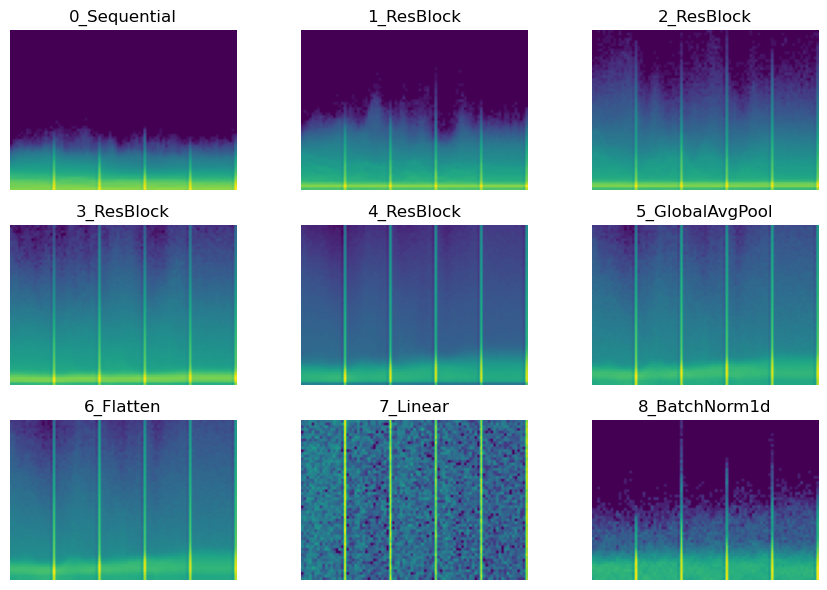

In [153]:
hooks.plot_acts()

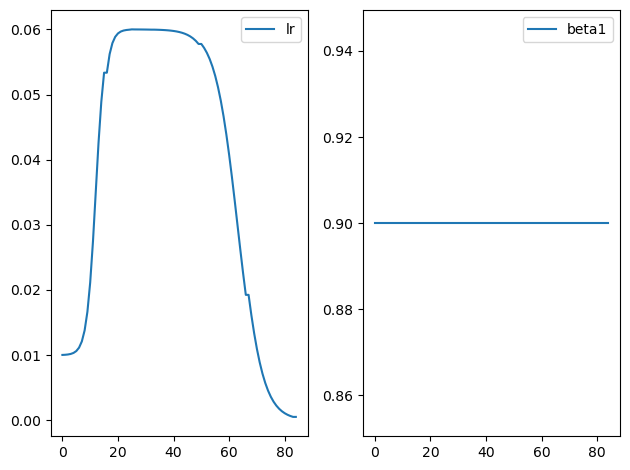

In [154]:
recorder.plot()

In [ ]:
torch.save(model, './models/fashion-augment.pth')